In [ ]:
!pip install --upgrade gdown   # update gdown
!gdown 1BhbQlsHiztZrYbq9ApcuLpTaFYn8a5cq  # Download database images
!gdown 1rOUMgzlwo44rUCc89wcdguYFbzIZK51_  # Download features extraction from database images

!unzip imgs_db.zip # unzip imgs_db
!mkdir /content/image_retrieval/db

!mv -T /content/img  /content/imgs_db # rename folder img to imgs_db
!mv /content/imgs_db /content/image_retrieval/db

!mkdir /content/image_retrieval/query_images
!wget https://www.dmarge.com/wp-content/uploads/2021/01/dwayne-the-rock-.jpg -P /content/image_retrieval/query_images
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/800px-Cat03.jpg -P /content/image_retrieval/query_images
!rm -rf /content/imgs_db.zip # delete imgs_db.zip file

In [ ]:
# load lib
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class SearchEngine:
    def __init__(self, model, dir_images, p_src_features):
        if model == "resnet50":
            self.model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', pooling="avg")
        if model == "convnext":
            self.model = tf.keras.applications.convnext.ConvNeXtSmall(include_top=False, weights='imagenet', pooling="avg")
        if model == "efficientnet":
            self.model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', pooling="avg")

            
        if p_src_features is None or not os.path.exists(p_src_features):
            self.db_extract_features(dir_images, p_src_features)
        db = np.load(p_src_features)
        self.path_imgs = db["p_imgs"]
        self.src_features = db["features"]   
    
    def load_img(self, img):
        if isinstance(img, str):
            img = cv2.imread(img)
        return img
        
    def preprocess(self, img):
        img = self.load_img(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        if len(img.shape) <= 3:
            img = img[None, :]
        return img

    # Extract feature from image
    def extractor(self, img):
        img = self.preprocess(img)
        feature = self.model(img).numpy()
        feature = feature/np.linalg.norm(feature)
        return feature
    
    def search(self, query_img, display=True, top=30):
        dest_feature = self.extractor(query_img)
        scores = (dest_feature @ self.src_features.T)[0]
        idxs_max = np.argsort(scores)[::-1][:top]
        if display:
            self.display(self.path_imgs[idxs_max])

        return list(zip(scores[idxs_max], self.path_imgs[idxs_max]))

    # Display result
    def display(self, paths, columns = 5, rows = 6):
        fig = plt.figure(figsize=(15, 15))
        for i, path in enumerate(paths):
            fig.add_subplot(rows, columns, i + 1)
            plt.imshow(plt.imread(path))
            plt.axis("off")
        plt.show()

    # Extract database images to features
    def db_extract_features(self, dir_images, p_src_features):
        path_imgs = []
        features = []
        for dir_cls in tqdm(os.listdir(dir_images)):
            for idx, name_img in enumerate(os.listdir(f"{dir_images}/{dir_cls}")):
                try:
                    p_img = f"{dir_images}/{dir_cls}/{name_img}"
                    feature = self.extractor(p_img)
                    features.extend(feature)
                    path_imgs.append(p_img)
                except:
                    print("error:", p_img)

        path_imgs = np.array(path_imgs)
        features = np.array(features)

        np.savez(p_src_features, p_imgs=path_imgs, features=features)

In [ ]:
dir_images="/content/image_retrieval/db/imgs_db"
p_src_features="/content/image_retrieval/db/80_features_db.npz"
model="resnet50"
search_engine = SearchEngine(model=model, dir_images=dir_images, p_src_features=p_src_features)

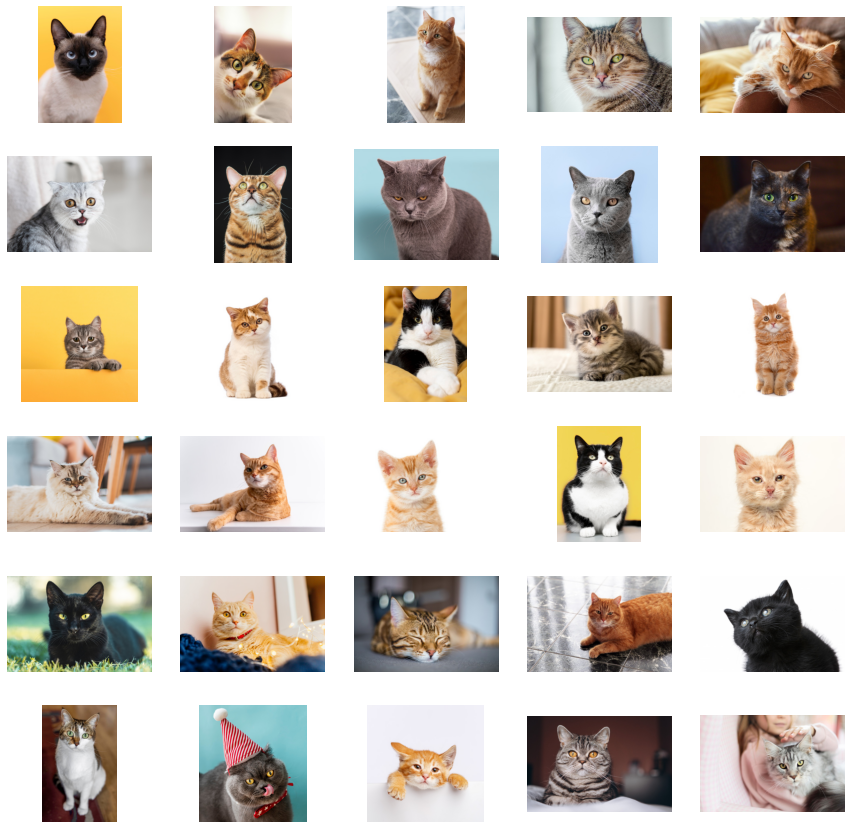

[(0.7886013,
  '/content/image_retrieval/imgs_db/animal_Cat/0.24464997843045755.jpg'),
 (0.7814766,
  '/content/image_retrieval/imgs_db/animal_Cat/0.9852347986189683.jpg'),
 (0.7701076,
  '/content/image_retrieval/imgs_db/animal_Cat/0.8315948990882573.jpg'),
 (0.76826686,
  '/content/image_retrieval/imgs_db/animal_Cat/0.9817143934593948.jpg'),
 (0.7579074,
  '/content/image_retrieval/imgs_db/animal_Cat/0.18614254649568074.jpg'),
 (0.7560402,
  '/content/image_retrieval/imgs_db/animal_Cat/0.06445019550030284.jpg'),
 (0.75371516,
  '/content/image_retrieval/imgs_db/animal_Cat/0.06529572635826586.jpg'),
 (0.749135,
  '/content/image_retrieval/imgs_db/animal_Cat/0.11235052800677947.jpg'),
 (0.7470038,
  '/content/image_retrieval/imgs_db/animal_Cat/0.48323312180718214.jpg'),
 (0.74353915,
  '/content/image_retrieval/imgs_db/animal_Cat/0.3553873074528303.jpg'),
 (0.7430265,
  '/content/image_retrieval/imgs_db/animal_Cat/0.6047941489526861.jpg'),
 (0.73261625,
  '/content/image_retrieval/imgs

In [ ]:
p_query = "/content/image_retrieval/query_images/800px-Cat03.jpg"
search_engine.search(p_query)

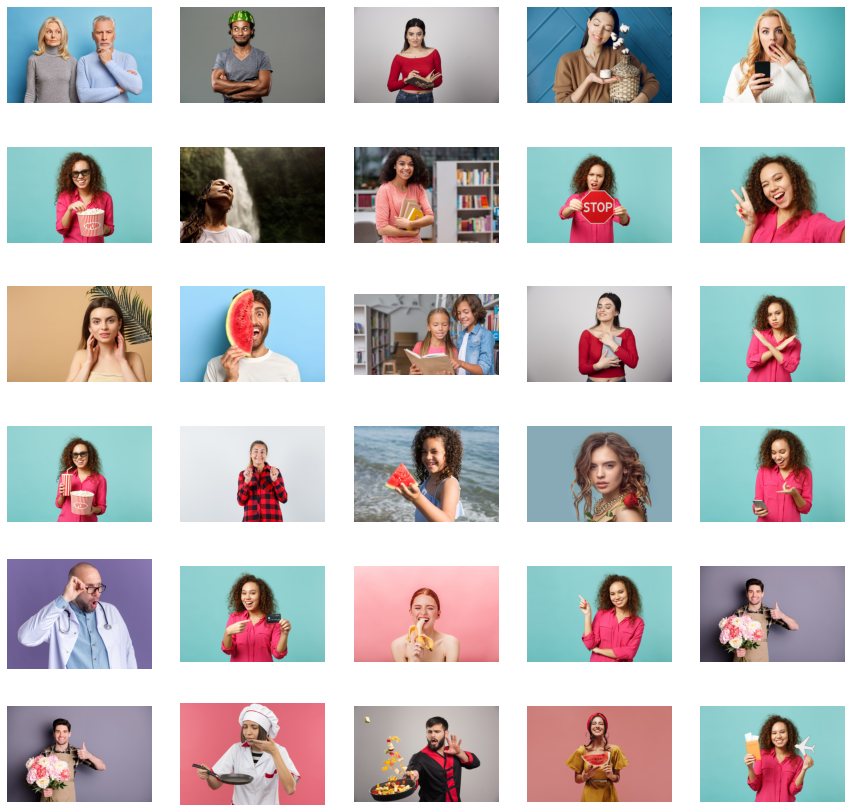

[(0.6912594,
  '/content/image_retrieval/imgs_db/furniture_Clothes/0.158860828770782.jpg'),
 (0.6871021,
  '/content/image_retrieval/imgs_db/plant_watermelon/0.5437576084553831.jpg'),
 (0.67083025,
  '/content/image_retrieval/imgs_db/furniture_book/0.10749024625857428.jpg'),
 (0.670182,
  '/content/image_retrieval/imgs_db/plant_CottonPlant/0.7965272170095347.jpg'),
 (0.66634345,
  '/content/image_retrieval/imgs_db/furniture_Clothes/0.7063987962607056.jpg'),
 (0.6654832,
  '/content/image_retrieval/imgs_db/plant_Corn/0.21492063273418938.jpg'),
 (0.66541886,
  '/content/image_retrieval/imgs_db/scenery_waterfall/0.9975141776972539.jpg'),
 (0.66437876,
  '/content/image_retrieval/imgs_db/furniture_Bookcase/0.015770883592431284.jpg'),
 (0.6620927,
  '/content/image_retrieval/imgs_db/furniture_Clothes/0.9661403711086842.jpg'),
 (0.6574924,
  '/content/image_retrieval/imgs_db/furniture_Clothes/0.35246025444446416.jpg'),
 (0.65709305,
  '/content/image_retrieval/imgs_db/plant_Fern/0.3477371272

In [ ]:
p_query = "/content/image_retrieval/query_images/dwayne-the-rock-.jpg"
search_engine.search(p_query)